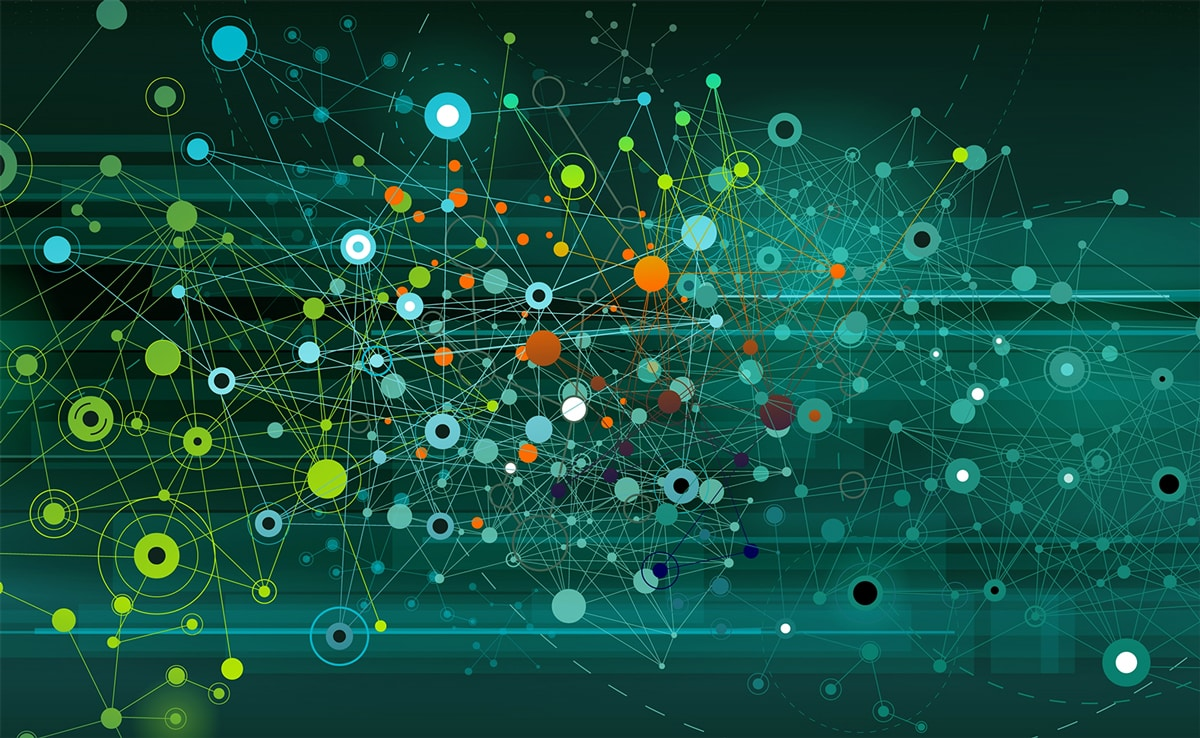
# Livrable 1

## Classification binaire

### Groupe de projet :
- Rémi Papin
- Fabien Richard
- Zacharia Azzouzi
<br>
<br>

### Introduction

Dans un premier temps, ce premier livrable consiste en la réalisation d'un classificateur binaire. Ce classificateur à pour role de séparé les datasets fournis en deux groupe, un groupe "photo" et un groupe "pas photo" :
- Photo
- Painting
- Schematics
- Sketch
- Texte



## Import

L'ensemble des imports des bibliothèques pour mener à bien ce projet.

In [10]:
import os
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from PIL import Image
import configuration
import fidle.pwk as pwk
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import datetime
import pathlib
from tensorboard.plugins.hparams import api as hp
from keras.utils.vis_utils import plot_model
%matplotlib inline

## Datasets

Pour 

In [12]:
image_h = 180
image_w = 180
batch_s = 32

data_dir = configuration.data_dir
train_set = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  labels = "inferred",
  validation_split= 0.8, 
  subset = "training",
  seed=42,
  batch_size=batch_s,
  image_size=(image_h, image_w),
)

# Le test_set
validation_set = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  labels = "inferred",
  validation_split= 0.2,
  subset = "validation",
  seed=42,
  batch_size=batch_s,
  image_size=(image_h, image_w),
)

class_names = train_set.class_names
print(class_names)

Found 36472 files belonging to 4 classes.
Using 7295 files for training.
Found 36472 files belonging to 4 classes.
Using 7294 files for validation.
['Painting', 'Photo', 'Schematics', 'Text']


## Visualisation

Dans un second temps nous allons voir la répartion des dataset, pour une visualisation des données.

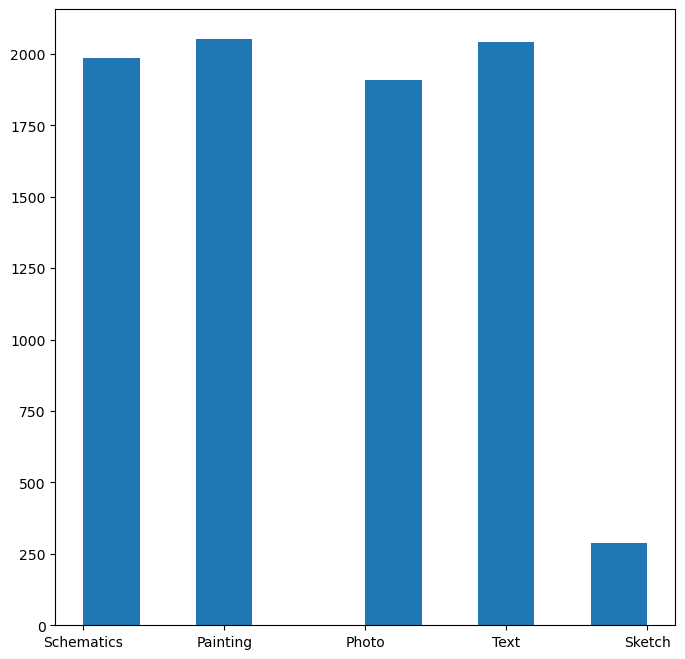

In [3]:
# Répartition des classes

# label_list = []
# i=0
# plt.figure(figsize=(8, 8))
# for images, labels in train_set.take(-1):
#     i += 1
#     print(i)
# for label in labels.numpy():
#     label_list.append(class_names[label])
# for i in range(9):
#     ax =  plt.subplot(3, 3, i + 1)
#     plt.title(class_names[labels[i]])
#     plt.imshow(images[i].numpy().astype("uint8"))
#     plt.axis("off")

# plt.hist(label_list)
# plt.show()


### Batch info

Le image_batch est un tenseur de la forme (256, 180, 180, 3) . Ceci est un lot de 256 images de forme 180x180x3 (la dernière dimension se réfère à des canaux de couleur RVB). 

Le label_batch est un tenseur de la forme (256,) , ceux - ci sont des étiquettes correspondant aux 256 images.

In [13]:
for image_batch, labels_batch in train_set:
   print(image_batch.shape)
   print(labels_batch.shape)
   break


(32, 180, 180, 3)
(32,)


## Mise en cache

In [15]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_set = train_set.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
validation_set = validation_set.cache().prefetch(buffer_size=AUTOTUNE)

## Construction du modèle 1 couche de convolution
Pour réaliser ce modèle nous avons créé une architecture reposant sur plusieurs couches :

- Une layers Rescaling :
- Une layers Conv2D :
- Une layers MaxPooling2D :
- Une layers Dropout :
- Une layers Flatten :
- Une layers Dense :
- Une layers Dense :


In [16]:
num_classes = len(class_names)
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal",
                      input_shape=(image_h,
                                  image_w,
                                  3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1)
  ]
)

# Le modèle
model_single_layer = Sequential([
  data_augmentation,
  layers.Rescaling(1./255, input_shape=(image_h, image_w, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(32, activation='relu'),
  layers.Dense(num_classes)
])
# Compilation du modèle
model_single_layer.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir, histogram_freq=1)
hparams_callback = hp.KerasCallback(log_dir, {
    'num_relu_units': 16,
    'dropout': 0.2
})
# Résumé du modèle
model_single_layer.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 90, 90, 16)        0         
                                                                 
 flatten_1 (Flatten)         (None, 129600)            0         
                                                      

### Checkpoint

Pour ne pas perdre du temps à ré entrainer les models à chaque fois nous réalisons des checkpoints nous permettant de conserver les valeurs de notre modèle le plus performant. 

In [17]:
# Prepare for model checkpoints
checkpoint_path = "training/cp_single_layer_{epoch:02d}-{val_accuracy:.2f}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 monitor='val_accuracy',
                                                 save_best_only=True,
                                                 save_weights_only=True,
                                                 verbose=1,
                                                 mode='max')

### Entrainement du modèle

Epoch 1/5
228/228 [==============================] - ETA: 0s - loss: 1.2626 - accuracy: 0.5638
Epoch 00001: val_accuracy improved from -inf to 0.68056, saving model to training/cp_single_layer_01-0.68.ckpt
228/228 [==============================] - 394s 1s/step - loss: 1.2626 - accuracy: 0.5638 - val_loss: 0.6918 - val_accuracy: 0.6806
Epoch 2/5
228/228 [==============================] - ETA: 0s - loss: 0.6457 - accuracy: 0.7206
Epoch 00002: val_accuracy improved from 0.68056 to 0.74075, saving model to training/cp_single_layer_02-0.74.ckpt
228/228 [==============================] - 254s 1s/step - loss: 0.6457 - accuracy: 0.7206 - val_loss: 0.6154 - val_accuracy: 0.7407
Epoch 3/5
228/228 [==============================] - ETA: 0s - loss: 0.5709 - accuracy: 0.7504
Epoch 00003: val_accuracy improved from 0.74075 to 0.76981, saving model to training/cp_single_layer_03-0.77.ckpt
228/228 [==============================] - 213s 935ms/step - loss: 0.5709 - accuracy: 0.7504 - val_loss: 0.5489 

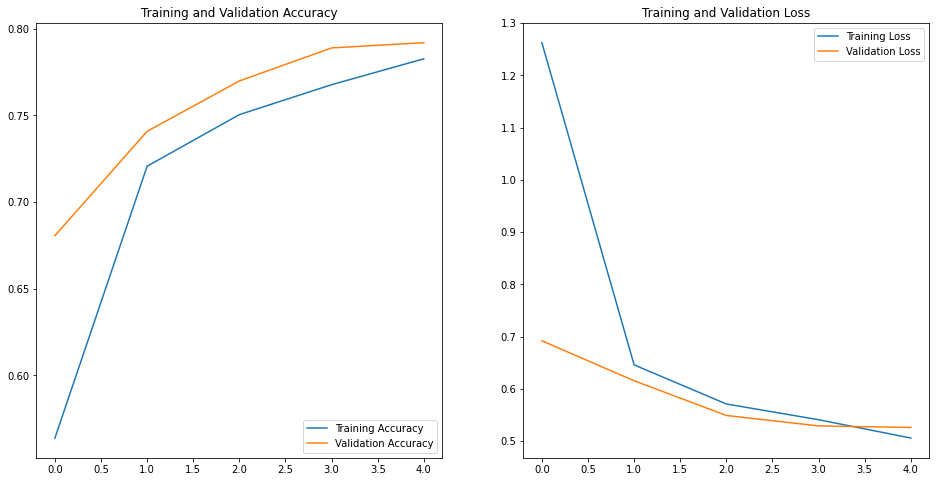

In [18]:
epochs=5
history = model_single_layer.fit(
  train_set,
  validation_data=validation_set,
  epochs=epochs,
  callbacks=[cp_callback,tensorboard_callback]
)

# Save the model
save_path = "checkpoints/"+datetime.datetime.now().strftime("%d-%m-%Y_%H-%M-%S")+"-"+str(history.history['val_accuracy'][-1])+".ckpt"
model_single_layer.save_weights(save_path)

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Construction du modèle 3 couche de convolution

In [19]:
num_classes = len(class_names)
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal",
                      input_shape=(image_h,
                                  image_w,
                                  3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1)
  ]
)

# Le modèle
model_multiple_layers = Sequential([
  data_augmentation,
  layers.Rescaling(1./255, input_shape=(image_h, image_w, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(32, activation='relu'),
  layers.Dense(num_classes)
])
# Compilation du modèle
model_multiple_layers.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir, histogram_freq=1)
hparams_callback = hp.KerasCallback(log_dir, {
    'num_relu_units': 16,
    'dropout': 0.2
}
                                    
                                    )
# Résumé du modèle
model_multiple_layers.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_4 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

### Checkpoint

Pour ne pas perdre du temps à ré entrainer les models à chaque fois nous réalisons des checkpoints nous permettant de conserver les valeurs de notre modèle le plus performant. 

In [20]:
# Prepare for model checkpoints
checkpoint_path = "training/cp_multiple_layers_{epoch:02d}-{val_accuracy:.2f}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 monitor='val_accuracy',
                                                 save_best_only=True,
                                                 save_weights_only=True,
                                                 verbose=1,
                                                 mode='max')

### Entrainement du modèle

Epoch 1/5
228/228 [==============================] - ETA: 0s - loss: 0.7106 - accuracy: 0.6812
Epoch 00001: val_accuracy improved from -inf to 0.75240, saving model to training/cp_multiple_layers_01-0.75.ckpt
228/228 [==============================] - 468s 2s/step - loss: 0.7106 - accuracy: 0.6812 - val_loss: 0.5803 - val_accuracy: 0.7524
Epoch 2/5
228/228 [==============================] - ETA: 0s - loss: 0.5185 - accuracy: 0.7756
Epoch 00002: val_accuracy improved from 0.75240 to 0.78037, saving model to training/cp_multiple_layers_02-0.78.ckpt
228/228 [==============================] - 461s 2s/step - loss: 0.5185 - accuracy: 0.7756 - val_loss: 0.5651 - val_accuracy: 0.7804
Epoch 3/5
228/228 [==============================] - ETA: 0s - loss: 0.4611 - accuracy: 0.8004
Epoch 00003: val_accuracy did not improve from 0.78037
228/228 [==============================] - 316s 1s/step - loss: 0.4611 - accuracy: 0.8004 - val_loss: 0.5511 - val_accuracy: 0.7746
Epoch 4/5
228/228 [==============

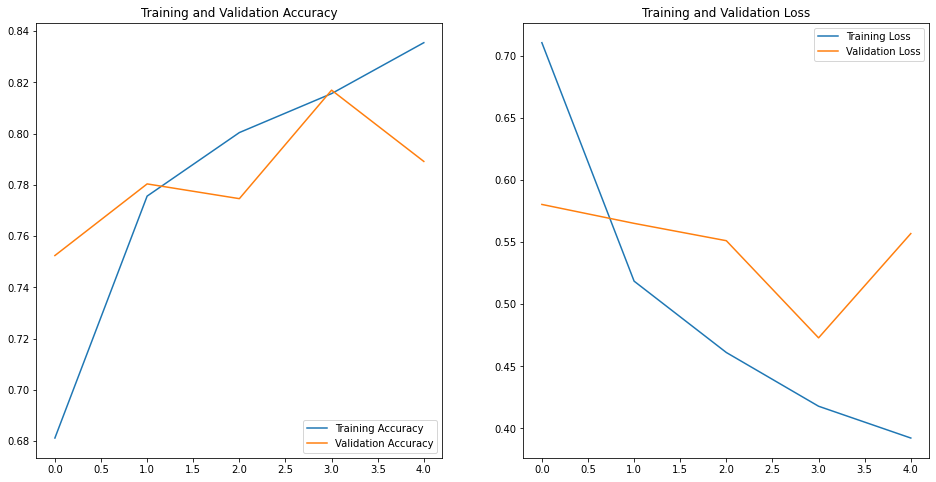

In [21]:
# Entrainement du modèle
epochs=5
history = model_multiple_layers.fit(
  train_set,
  validation_data=validation_set,
  epochs=epochs,
  callbacks=[cp_callback,tensorboard_callback]
)

# Save the model
save_path = "checkpoints/"+datetime.datetime.now().strftime("%d-%m-%Y_%H-%M-%S")+"-"+str(history.history['val_accuracy'][-1])+".ckpt"
model_multiple_layers.save_weights(save_path)

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [22]:
!tensorboard dev upload --logdir ./logs \
  --name "Livrable 1 : Projet Datascience - Leyenda." \
  --description "Model de classification binaire de photos / autres classes." \
  --one_shot


New experiment created. View your TensorBoard at: https://tensorboard.dev/experiment/WdGwSaMtRmixcqZk8JmweA/

[2021-12-14T15:19:34] Started scanning logdir.
[2021-12-14T15:19:37] Total uploaded: 60 scalars, 80 tensors (57.4 kB), 2 binary objects (219.2 kB)
[2021-12-14T15:19:37] Done scanning logdir.


Done. View your TensorBoard at https://tensorboard.dev/experiment/WdGwSaMtRmixcqZk8JmweA/


## Validation

## Test de l'accuracy du model

In [23]:
for x, y in validation_set:
    predictions = np.concatenate([predictions, np.argmax(model_with_data_augmentation.predict(x), axis = -1)])
    labels = np.concatenate([labels, np.argmax(y.numpy(), axis=-1)])

NameError: name 'predictions' is not defined

In [24]:
test_loss, test_acc = model_multiple_layers.evaluate(validation_set, verbose=2)

print('\nTest accuracy:', test_acc)

y_sigmoid = model_multiple_layers.predict(validation_set)
y_pred    = np.argmax(y_sigmoid, axis=-1)

KeyboardInterrupt: 

### Matrice de confusion

In [ ]:
pwk.plot_confusion_matrix(y_test,y_pred,range(10),normalize=True, save_as='06-confusion-matrix')

## Exemple d'erreurs

In [ ]:
errors=[ i for i in range(len(x_test)) if y_pred[i]!=y_test[i] ]
errors=errors[:min(24,len(errors))]
pwk.plot_images(x_test, y_test, errors[:15], columns=6, x_size=2, y_size=2, y_pred=y_pred, save_as='05-some-errors')

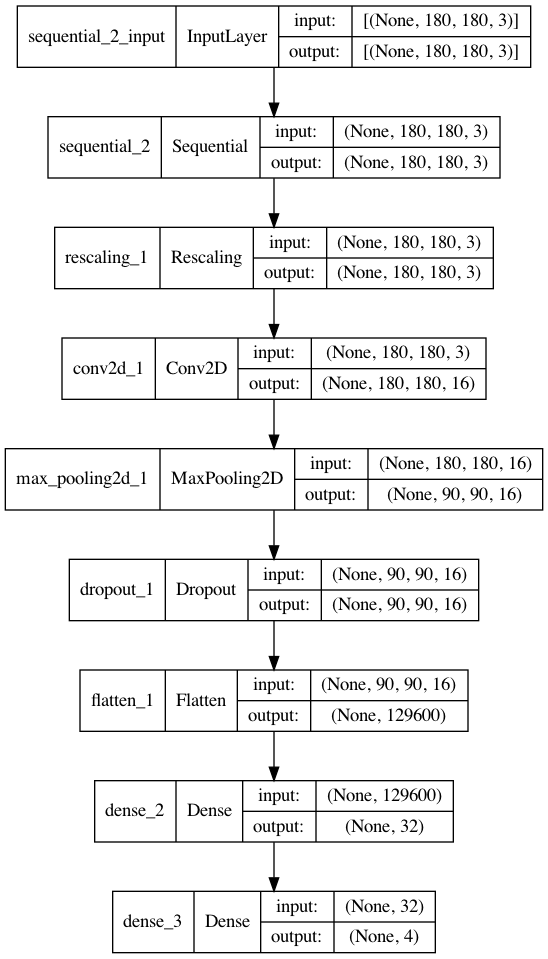

In [25]:
plot_model(model_single_layer, to_file='image/model_single_layer.png', show_shapes=True)

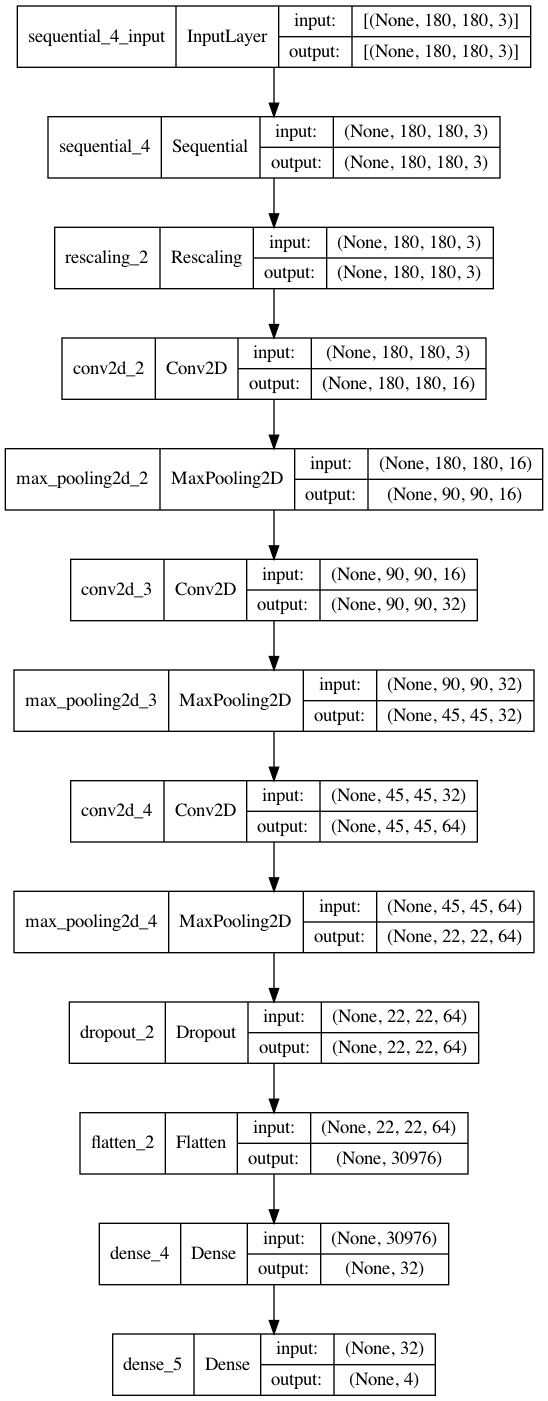

In [26]:
plot_model(model_multiple_layers, to_file='image/model_multiple_layers.png', show_shapes=True)